# Financial Time Series Regime Analysis
## Markov-Chain Autoregressive Model Exploration
Rhesa Budhidarmo (https://www.linkedin.com/in/rhesa-budhidarmo/)

Consider a simple autoregressive $AR(p)$ model for a time series:
$$x_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i x_{t-i} + \epsilon_t \qquad \epsilon_t \sim N(0,\sigma^2)$$
where:
- $ x_t $ = observation at time $t$
- $ x_{t-i} $ = observation at time $t-i$
- $ \alpha_0 $ = regression intercept
- $ \alpha_i $ = autoregressive coefficient for lag $t-i$
- $ \epsilon_t$ = white noise with mean = 0 & constant variance $\delta^2$

The values of the parameters $\{\alpha_0,\alpha_1,\alpha_2,...,\alpha_p\}$ and the variance of the innovation term $\delta^2$ are usually assumed to remain constant. However, it is well-known that large-scale structural changes, or regime shifts, occur from time to time due to, for example, macroeconomic developments or geopolitical events. This is often accompanied by significant changes in the behavior of the time series. In other words, the values of the parameters can change as one regime ($s_t$) switches to another [1]:
<br>
$$x_t =
\begin{cases}
\alpha_{00} + \alpha_{10} x_{t-1} + \alpha_{20} x_{t-2} + \cdots + \alpha_{p0} x_{t-p} +\epsilon_t & \quad \epsilon_t \sim N(0,\sigma_0^2 ) & \quad \text{for regime $s_0$}\\
\alpha_{01} + \alpha_{11} x_{t-1} + \alpha_{21} x_{t-2} + \cdots + \alpha_{p1} x_{t-p} +\epsilon_t & \quad \epsilon_t \sim N(0,\sigma_1^2 ) & \quad \text{for regime $s_1$}\\
\alpha_{02} + \alpha_{12} x_{t-1} + \alpha_{22} x_{t-2} + \cdots + \alpha_{p2} x_{t-p} +\epsilon_t & \quad \epsilon_t \sim N(0,\sigma_2^2 ) & \quad \text{for regime $s_2$}\\
\vdots
\end{cases}
$$

To try to capture regime-dependent dynamics of a regression model, we can combine a Markov-switching (MS) model with an AR model. The Markov property specifies that the probability of transitioning to next regime (or "state") ($s_{t+1}$) depends only on which state the system is currently in ($s_t$).
<br>
<br>In this study, we will evaluate simple 2-state ($s_t \in \{0,1\}$) Markov switching AR (MS-AR) models. The transition matrix below captures the conditional probability of switching from one state to another given the previous state [2]:
<br>
<br>
$$
P \left(s_t\, \middle |\, s_{t-1}\right) = \begin{bmatrix}
p_{00} & p_{10} \\
1-p_{00} & 1-p_{10}
\end{bmatrix}
$$

As an example to demonstrate MS-AR models, Brent crude oil futures weekly price returns data from 2007 until today will be analyzed. We will estimate the state-dependent model intercept ($\alpha_0$), any relevant coefficients for lagged data points ($\{\alpha_1,\alpha_2,...,\alpha_p\}$), the variance of the innovation term ($\sigma^2$), as well as the transition probabilities $p_{00}$ and $p_{10}$ using Maximum Likelihood Estimation method as implemented in ```statsmodels``` Python library [2].

In [1]:
import pandas as pd
from numpy import std
import matplotlib.pyplot as plt
import yfinance as yf
from seaborn import FacetGrid
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# download weekly price data from Yahoo Finance & calculate weekly returns
df = yf.download('BZ=F',start="2007-01-01",end="2024-07-01",interval='1wk')
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2007-08-06,74.540001,74.599998,68.970001,70.389999,70.389999,29923,-0.058328
2007-08-13,70.959999,72.199997,69.050003,70.440002,70.440002,19759,0.000710
2007-08-20,69.680000,70.809998,68.180000,70.620003,70.620003,20545,0.002555
2007-08-27,70.440002,73.059998,69.489998,72.690002,72.690002,17308,0.029312
2007-09-03,72.230003,75.639999,72.050003,75.070000,75.070000,18660,0.032742


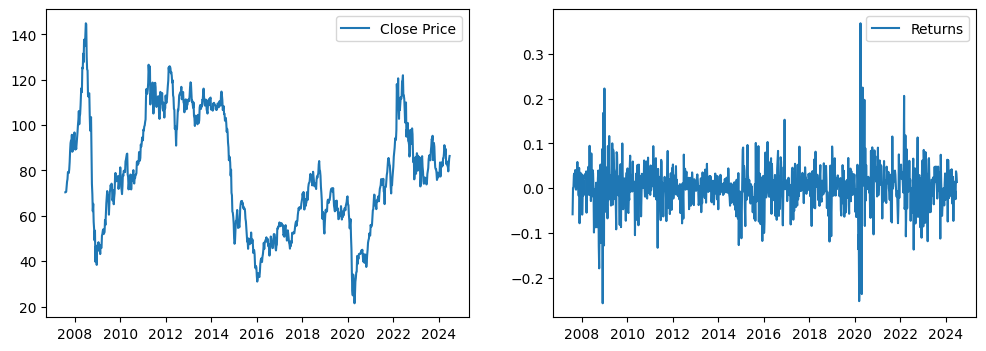

In [3]:
# plot close price & weekly returns
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(df['Close'],label='Close Price')
axs[0].legend()
axs[1].plot(df['Returns'],label='Returns')
axs[1].legend()
plt.show()

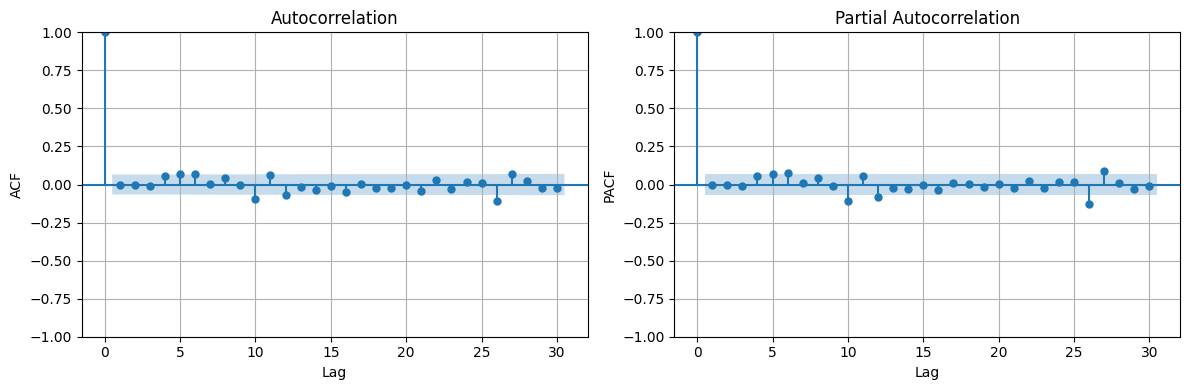

In [4]:
# ACF and PACF plots for weekly returns
fig,axs = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(df['Returns'],ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid()

sm.graphics.tsa.plot_pacf(df['Returns'],ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
axs[1].grid()

plt.tight_layout()
plt.show()

The ACF and PACF plots for the weekly returns data (above) show that there are seemingly no strongly correlated lags. However, the lags 6, 10, 12, 26, 27 may still be significant.

In [5]:
# ADF test for weekly returns
adf_result = adfuller(df['Returns'])
print('ADF Test for Weekly Returns')
print('---------------------------------')
print(f'Statistic:\t\t{adf_result[0]}')
print(f'p-value:\t\t{adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: \t{value}')
print('')

ADF Test for Weekly Returns
---------------------------------
Statistic:		-8.512448663780635
p-value:		1.1576439862695015e-13
Critical Value 1%: 	-3.437897435722137
Critical Value 5%: 	-2.8648716746706326
Critical Value 10%: 	-2.568544030438542



In addition to the miniscule p-value < 0.01, the ADF statistic for the returns data is smaller than the 1 % critical value. Therefore, we can reject $H_0$ and conclude that this series does not have a unit root, and is stationary.

We can now start building a Markov-switching AR model. We will start by building an MS-AR(1) below (denoted by parameter ```order=1```). As mentioned above, we would build a 2-state model (```k_regimes=2```). The ```trend='c'``` parameter was chosen to allow for varying intercepts between regimes (without including any time-varying trend variable). From the weekly returns chart above, we can also see volatility clusters. Therefore, the ```switching_variance``` parameter was set to ```True```.

In [6]:
# fit Markov-switching Autoregressive model with 1 lag
model0 = sm.tsa.MarkovAutoregression(df['Returns'], k_regimes=2, order=1, trend='c',
                                    switching_ar=True, switching_trend=True,
                                    switching_variance=True)
results0 = model0.fit()
print(results0.summary())

                         Markov Switching Model Results                         
Dep. Variable:                  Returns   No. Observations:                  880
Model:             MarkovAutoregression   Log Likelihood                1492.829
Date:                  Tue, 02 Jul 2024   AIC                          -2969.657
Time:                          15:56:18   BIC                          -2931.418
Sample:                               0   HQIC                         -2955.034
                                  - 880                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.691      0.091      -0.000       0.005
sigma2         0.0016   8.75e-05    

From the first MS-AR(1) model above, the volatility ($\sigma^2$) of the innovation terms is considerably different between the two regimes, and that they are statistically significant. However, although the intercept and the coefficient for the lag 1 term may appear different between regimes, they are not significant. If we go back to the ACF and PACF plots above, we may want to include other lags in our model too. However, to avoid building an overly complex model, we will now fit the data to a model that includes up to 6 lags: MS-AR(6) (see below).

In [7]:
# fit Markov-switching Autoregressive model with 6 lags
model = sm.tsa.MarkovAutoregression(df['Returns'], k_regimes=2, order=6, trend='c',
                                    switching_ar=True, switching_trend=True,
                                    switching_variance=True)
results = model.fit()
print(results.summary())

                         Markov Switching Model Results                         
Dep. Variable:                  Returns   No. Observations:                  875
Model:             MarkovAutoregression   Log Likelihood                1503.494
Date:                  Tue, 02 Jul 2024   AIC                          -2970.988
Time:                          15:56:55   BIC                          -2885.052
Sample:                               0   HQIC                         -2938.116
                                  - 875                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.001      3.764      0.000       0.003       0.008
sigma2         0.0012      0.000    

Compared to the first MS-AR(1) model, the BIC increases slightly for the second MS-AR(6) model (because we've added complexity to the model). However, the Log Likelihood increases and AIC decreases somewhat. In the first regime (Regime 0), we still observe insignificant coefficients for the lag terms (with only the intercept and the variance being the significant ones). However, in the second regime (Regime 1), lag 3 and lag 4 appear to be significant in addition to the intercept and variance. Moreover, the probabilities of the transition matrix $p_{00}$ and $p_{10}$ are also significant. We can conclude, for example, that the conditional probability of transitioning from regime $s_1$ to $s_0$ is around 21 % ($p_{10}$ = 0.211). However, when the series is in state $s_0$, it is likely to remain there ($p_{00}$ = 0.965).

In [8]:
# print the expected duration for each regime
print(results.expected_durations)

[28.30082503  4.72846875]


We can also expect that, on average, the first low-variance (i.e., low-volatility) regime $s_0$ to last for around 28 days, whereas the second high-variance regime $s_1$ usually lasts for around 4 - 5 days.

The change in (smoothed) transition probability of the low-variance ($s_0$) and high-variance ($s_1$) regime across the time series can be visualized below.

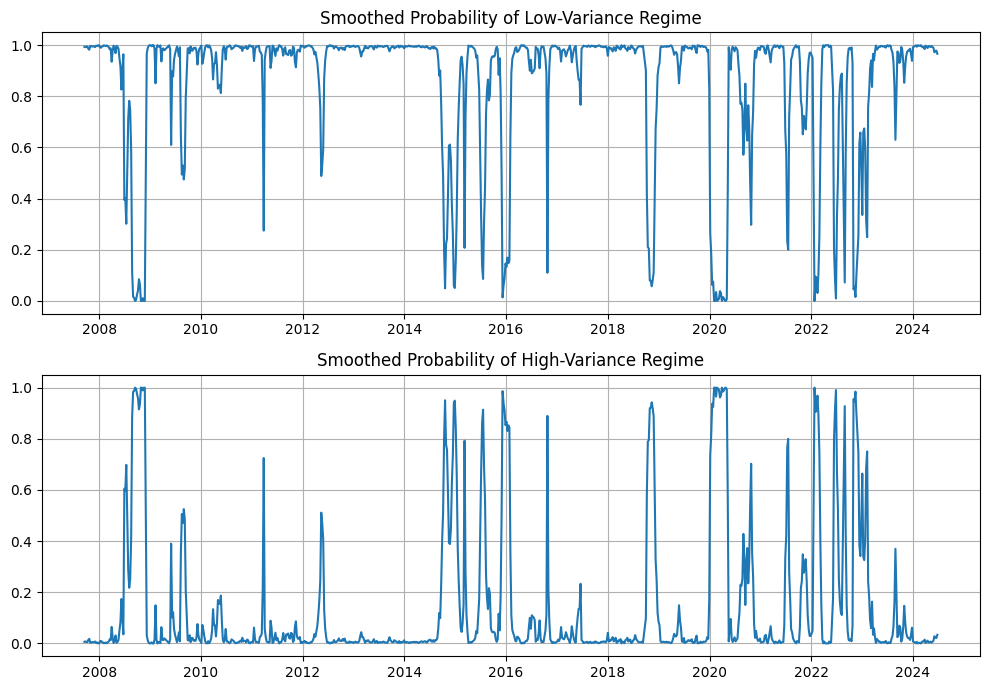

In [9]:
# plot smoothed probability of low- & high-variance regimes
fig, axs = plt.subplots(2,1, figsize=(10,7))
axs[0].plot(results.smoothed_marginal_probabilities[0])
axs[0].set_title('Smoothed Probability of Low-Variance Regime')
axs[0].grid()
axs[1].plot(results.smoothed_marginal_probabilities[1])
axs[1].set_title('Smoothed Probability of High-Variance Regime')
axs[1].grid()
plt.tight_layout()
plt.show()

(The following few code blocks were inspired and modified from references [3] and [4]). To obtain a better understanding regarding the regime shifts, the transition probabilities $p_{00}$ and $p_{10}$ were encoded into categorical variables (0 and 1) as follows: if $p_{00}$ > $p_{10}$, the series is in the first ($s_0$) low-variance regime and we assign a value of 0. The opposite is true for $s_1$ (we assign a value of 1 if $p_{01}$ > $p_{00}$). This encoded regime transition probabilities were then mapped on to the close price (below).

In [10]:
# encode regimes as either 0 or 1
low_var = list(results.smoothed_marginal_probabilities[0])
high_var = list(results.smoothed_marginal_probabilities[1])

regime_list = []

for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

# combine the encoded predicted regimes with the main dataframe
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['Regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))

regimes.head()

,Date,Regimes,Open,High,Low,Close,Adj Close,Volume,Returns
0,2007-09-17,0,75.540001,79.949997,75.540001,79.300003,79.300003,14303,0.040409
1,2007-09-24,0,78.650002,81.029999,76.379997,79.169998,79.169998,16943,-0.001639
2,2007-10-01,0,78.830002,79.239998,76.330002,78.900002,78.900002,18437,-0.003410
3,2007-10-08,0,78.339996,80.889999,75.669998,80.550003,80.550003,16358,0.020913
4,2007-10-15,0,81.400002,84.699997,81.370003,83.790001,83.790001,16407,0.040223


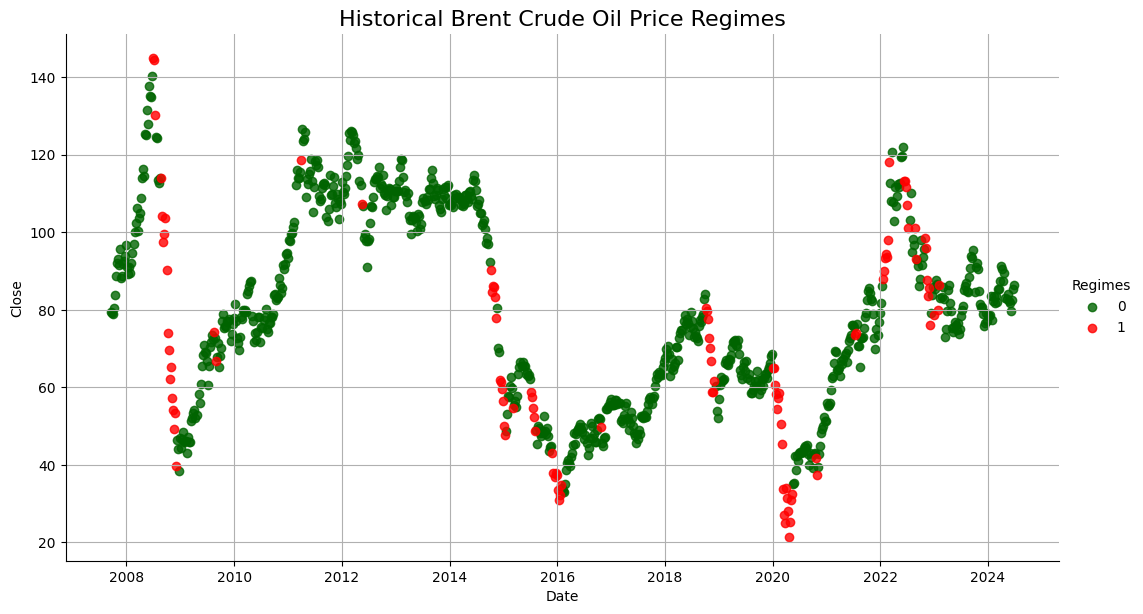

In [11]:
# map predicted regimes onto close price data
colors = 'darkgreen','red'
order = [0, 1]
fg = FacetGrid(data=regimes, hue='Regimes', hue_order=order,
                   palette=colors, aspect=1.8, height=6)
fg.map(plt.scatter, 'Date', 'Close', alpha=0.8).add_legend()
plt.title('Historical Brent Crude Oil Price Regimes', fontsize=16)
plt.grid()
plt.show()

From the chart above, we can observe that the second high-variance ($s_1$) regime often prevailed in bear markets and coincided with strong downtrends in the price of Brent crude oil futures in a number of occasions (highlighted in red). This result is, perhaps, not surprising because price tends to decline more rapidly (i.e., with higher variance) in a bear market in the midst of heightened autocorrelations (as, perhaps, indicated by the previous observation that lag 3 and lag 4 are significant in the $s_1$ regime).

To gain further understanding of how well our MS-AR(6) model describes the data, we will now focus our attention on the model residuals. Below, the weekly returns data are plotted (blue), and superimposed on them, the fitted data, with the error / innovation terms taken (orange), out are also shown. It is clear that, although the MS-AR model captures the general pattern of volatility clustering, the residuals still account for a large proportion of the variance observed in the data.

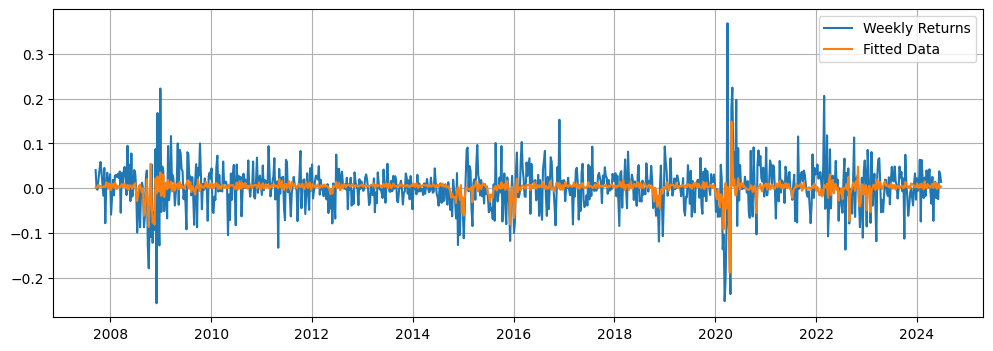

In [12]:
# plot returns data vs fitted data
fit_res = results.resid
fitted = df['Returns'] - fit_res
fig,axs = plt.subplots(figsize=(12,4))
axs.plot(df['Returns'],label='Weekly Returns')
axs.plot(fitted,label='Fitted Data')
plt.grid()
plt.legend()
plt.show()

The standardized residuals are plotted below (left). To visualize if the residuals are normally distributed, a QQ plot was also produced (right). Indeed, the QQ plot provides the first indication that the residuals are not normally distributed.

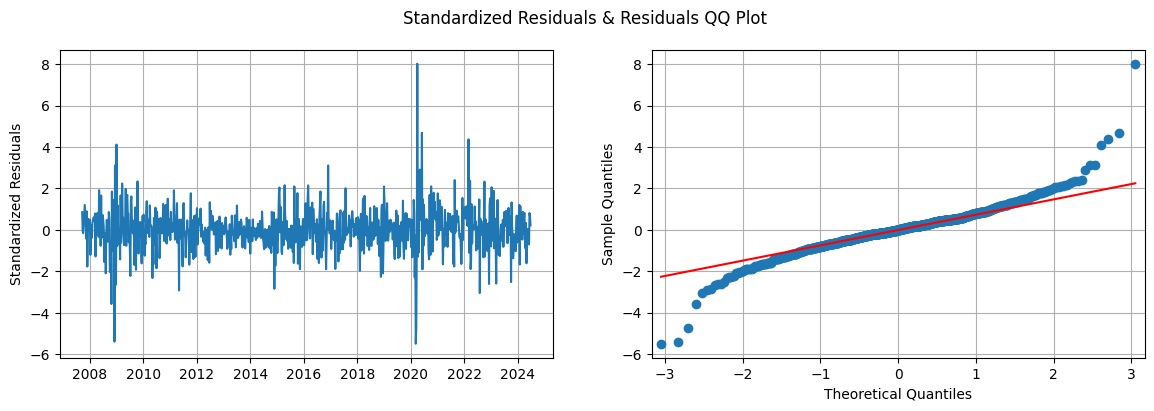

In [13]:
# calculate standardized residuals
fit_res_sta = fit_res / std(fit_res,ddof=1)

# plot standardized residuals & QQ-plot
fig,axs = plt.subplots(1,2,figsize=(14,4))
axs[0].plot(fit_res_sta)
axs[0].set_ylabel('Standardized Residuals')
axs[0].grid()
sm.qqplot(fit_res,line='q',fit=True,ax=axs[1])
axs[1].grid()
plt.suptitle('Standardized Residuals & Residuals QQ Plot')
plt.show()

To investigate if there are autocorrelations in the innovations, ACF and PACF plots of the residuals were generated. It is evident that some lags (especially, lags 10, 12, and 26) are significantly above or below the 95 % confidence interval band (below).

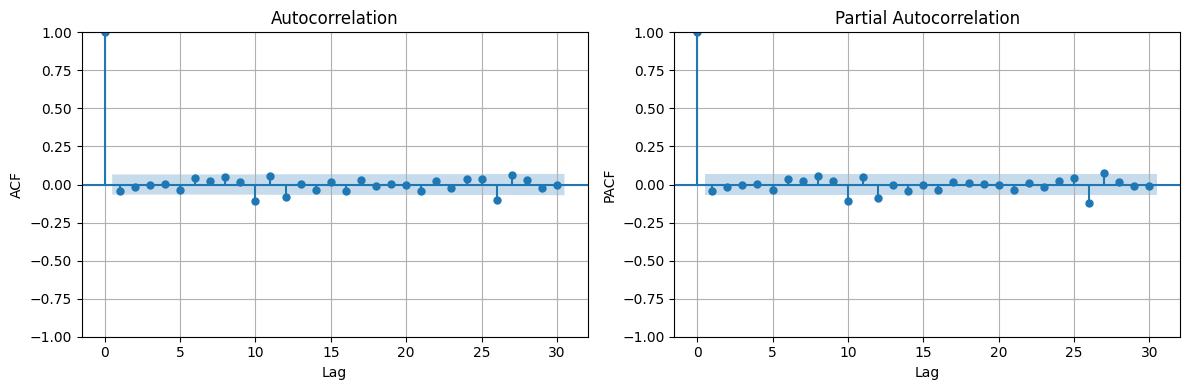

In [14]:
# ACF and PACF plots for model residuals
fig,axs = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(fit_res,ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid()

sm.graphics.tsa.plot_pacf(fit_res,ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
axs[1].grid()

plt.tight_layout()
plt.show()

Lastly, to corroborate the observation from the QQ plot above, Jarque-Bera & Shapiro-Wilk tests were also conducted on the model residuals.

In [15]:
# Jarque-Bera test for model residuals
name = ['JB Statistic', 'p-value', 'Skewness', 'Kurtosis']
jb_test = jarque_bera(fit_res)
for n in range(len(name)):
    print(f'{name[n]}:\t{jb_test[n]}')

JB Statistic:	2361.3954431119605
p-value:	0.0
Skewness:	0.3110923976833085
Kurtosis:	11.023876224301699


In [16]:
# Shapiro-Wilk test for model residuals
shapiro_test = stats.shapiro(fit_res)
print(f'Shapiro W:\t{shapiro_test.statistic}')
print(f'p-value:\t{shapiro_test.pvalue}')

Shapiro W:	0.9279509782791138
p-value:	4.526223098199916e-20


Overall, the QQ plot, as well as both Jarque-Bera and Shapiro-Wilk tests, provide strong evidence that the residuals of our MS-AR(6) model are not normally distributed. In addition, we can see from the ACF and PACF plots that some lags are still correlated. In other words, the errors are not independent. Therefore, there is ample room to improve this model in the future.

If we were to model the raw data using a simple AR model (without Markov-switching), we would be likely to overlook the abrupt increase in volatility in price movements when the market switched to $s_1$ from time to time. As we have seen above, this high-variance regime is frequently associated with steep drawdowns in price (which occurred, for example, during the global financial crises in 2008, or when oil production far exceeded demand in 2014, or when the COVID-19 pandemic crisis in 2020 took hold). In a recession period or a financial crisis, when (auto)correlations are high, the probability of transitioning from a low-variance to a high-variance regime may increase significantly. Therefore, by incorporating a Markov-switching model, we gain a more nuanced understanding of our data and may keep us informed during periods of high volatility.

Due to its versatility, Markov-switching models (and state-space model in general) have been used in many ways in combination with other time series models. For example, Cai (1994) demonstrated that Markov-switching can be combined with AutoRegressive Conditional Heteroskedasticity (ARCH) models to take into account varying volatility and regime shifts simultaneously [5]. In particular, since the residuals of our model is not normally distributed and display considerable kurtosis (as revealed in the Jarque-Bera test above), we may want to try to fit our data to Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) models with Student's t innovations. Indeed, this type of approach has been attempted by others (as summarized by Ardia (2007)). By combining Markov-switching and GARCH with t-distributed innovations, one can model changing volatility, shifting regimes, and high degree of kurtosis frequently encountered in financial data [6]. These are just some examples of other candidate models that we may want to test to improve our model in the future.

### **References**

1. Luck, Spencer. "Time Series Regime Analysis in Python." *Medium*, 13 October 2022, https://medium.com/@spencer13luck/time-series-regime-analysis-in-python-ffdc7aa005dd. Accessed on 1 July 2024.
2. "Markov switching autoregression models." *statsmodels.org*, https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html. Accessed on 2 July 2024.
3. Luck, Spencer. "Regime-Analysis." *GitHub*, 2022, https://github.com/SpencerLuck/Regime-Analysis/blob/main/RegimeAnalysis.ipynb. Accessed on 30 June 2024.
4. Maitra, Sarit. "Markov Regime Switching Non-Linear Model." *Medium*, 14 July 2020, https://sarit-maitra.medium.com/markov-regime-switching-non-linear-model-8ebfdf6eb755. Accessed on 2 July 2024.
5. Cai, Jun. "A Markov Model of Switching-Regime ARCH." *Journal of Business & Economic Statistics*, vol. 12, no. 3, July 1994, https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=59c158d6b41837a8468a7188619ee86cb3de2bc4. Accessed on 2 July 2024.
6. Ardia, David. "Bayesian Estimation of the Markov-switching GARCH(1,1) Model with Student-t Innovations." *R/Rmetrics User and Developer Workshop*, July 2007, https://pdfs.semanticscholar.org/dc43/f41f89014cbaa92601067d8839ac259ca721.pdf. Accessed on 2 July 2024.